In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import math
import os
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from CustomDataset import CustomDataset, RoadLoad, RoadLoad_seq
import matplotlib.pyplot as plt
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import time
import click
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
import torch
from tqdm import tqdm
import copy
import csv
import ray
from ray import tune
import pandas as pd
from ray.tune.schedulers import ASHAScheduler
import shutil
import gc
torch.manual_seed(0)
from GPUtil import showUtilization as gpu_usage
gpu_usage()
torch.cuda.empty_cache()
gc.collect()

torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.current_device())



| ID | GPU | MEM |
------------------
|  0 |  0% | 16% |
|  1 |  0% |  0% |
1


In [2]:
#from torchvision import models
def createDeepLabv3(outputchannels=1):
    model = torchvision.models.segmentation.deeplabv3_resnet50(weights='DeepLabV3_ResNet50_Weights.DEFAULT',progress=True)
    model.classifier = DeepLabHead(2048,outputchannels)
    model.train()
    return model

In [3]:
# Create the dataloader
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                    std=[0.229,0.224,0.225])
data_transforms = {
    'Train':
    transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]),
    'Validation':
    transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]),
}
dataset = CustomDataset(target_type = 'poly')

batch_size = 2
TRAIN_SIZE= math.floor(dataset.__len__()*0.70)
VALIDATION_SIZE = math.floor((dataset.__len__() - TRAIN_SIZE)/2)
TEST_SIZE = math.floor(dataset.__len__() - (TRAIN_SIZE+VALIDATION_SIZE))
print([dataset.__len__(),TRAIN_SIZE, VALIDATION_SIZE, TEST_SIZE])
image_datasets = {
    'Train': 
        TRAIN_SIZE,
    'Validation':
        VALIDATION_SIZE,
    'Test':
        TEST_SIZE}

trainset, validationset, testset = random_split(dataset,[TRAIN_SIZE, VALIDATION_SIZE, TEST_SIZE])

[1155, 808, 173, 174]


In [4]:
def train_model(model, criterion, dataloaders, optimizer, metrics, bpath,
                num_epochs,weights_name, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    # Initialize the log file for training and Validationing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Validation_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Validation_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    
    for epoch in range(1, num_epochs + 1):
        #gpu_usage()
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and Validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            # Iterate over data.
            for (inputs,label) in tqdm(iter(dataloaders[phase])):
                inputs = inputs.to(device)
                label = label.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    #loss = criterion(outputs['out'].squeeze(), label.squeeze())
                    loss = torchvision.ops.sigmoid_focal_loss(outputs['out'].squeeze(), torch.squeeze(label), reduction = 'mean')
                    y_pred = outputs['out'].detach().cpu().numpy()
                    y_pred = np.squeeze(y_pred)
                    y_true = label.detach().cpu().numpy()
                    for name, metric in metrics.items():
                        y_true = y_true.ravel()
                        y_pred = y_pred.ravel()
                        #print(y_true.shape, y_pred.shape)
                        #print(np.max(y_true), np.min(y_true), np.max(y_pred),np.min(y_pred))
                        try:
                            if name == 'f1_score':
                                # Use a classification threshold of 0.1
                                batchsummary[f'{phase}_{name}'].append(
                                    metric(y_true > 0, y_pred > 0.1))
                            else:
                                batchsummary[f'{phase}_{name}'].append(
                                    metric(y_true.astype('uint8'), y_pred))
                        except:
                            batchsummary[f'{phase}_{name}'].append(0)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
                inputs = None
                label = None
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Validation' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, os.path.join(bpath, weights_name))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
# lr 

In [6]:
def main(exp_directory, epochs, batch_size, device, weights_name, lr = 1e-4, betas = (0.9,0.9999)):
    # Create the deeplabv3 resnet101 model which is pretrained on a subset
    # of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
    
    train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validationset, batch_size=batch_size, shuffle=True)
    dataloaders = {
        'Train':
            train_dataloader,
        'Validation':
            validation_dataloader
    }
    

    model = createDeepLabv3().to(device)
    #print(model)
    model.train()
    # Create the experiment directory if not present
    exp_directory = Path(exp_directory)
    if not exp_directory.exists():
        exp_directory.mkdir()
    
    # Specify the loss function
    criterion = torch.nn.MSELoss(reduction='mean')
    # Specify the optimizer with a lower learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, betas = betas)

    # Specify the evaluation metrics
    metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

    _ = train_model(model,
                    criterion,
                    dataloaders,
                    optimizer,
                    device = device,
                    bpath=exp_directory,
                    metrics=metrics,
                    num_epochs=epochs,
                    weights_name = weights_name)

    # Save the trained model
    #torch.save(model, exp_directory / 'weights_deeplab_2.pt')
    

exp_directory = 'models/pytorch/'
weights_name = "weights_deeplab_test2.pt"
#
#main(exp_directory, epochs = 1, batch_size = 2, device=device, weights_name = weights_name, lr = 0.0001, betas = (0.9,0.9999))

In [7]:
# Hyper parameter search:
exp_directory = 'models/pytorch/hpt/'
lr_list = [1e-1, 1e-2, 1e-4]
beta_list = [(0.9,0.9999),(0.7,0.9999),(0.9999,0.7)]
epochs = 50
def hpt(exp_directory, lr_list, epochs, bs_list):
    for lr in lr_list:
        for betas in beta_list:
            name = "lr" + str(lr)+ "_" + "beta"+str(betas)
            name_pt = name + ".pt"
            print(name)
            main(exp_directory, epochs = epochs, batch_size = batch_size, device=device,weights_name = name_pt, lr = lr, betas = betas)
            model = None
            torch.cuda.empty_cache()
            gc.collect()
            #rename
            os.rename(Path(exp_directory+'log.csv').resolve(), Path(exp_directory+ name+ '.csv').resolve())
    print("done")
#hpt(exp_directory, lr_list, epochs, beta_list)
# lr0.1_beta(0.9999,0.7) er fyldt med nan, starter fra 1e-2

models/pytorch/hpt/50 epochs/lr0.0001_beta(0.7, 0.9999).csv 1.7488620869698934e-05


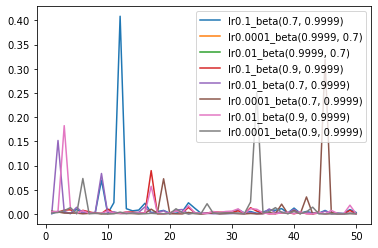

In [8]:
# hyper parameter evaluation:
def plot_loss_hpt(path_to_dir):
    filenames = os.listdir(path_to_dir)
    filenames = [ os.path.join(path_to_dir, filename) for filename in filenames if filename.endswith(".csv") ]
    y_low = 1
    for filename in filenames:
        y = pd.read_csv(filename)["Validation_loss"].values
        #print(filename, y)
        x = np.arange(0,len(y))+1
        name = os.path.splitext(os.path.basename(filename))[0]
        #print(name, y)
        #with plt.style.context("fivethirtyeight"):
        line = plt.plot(x,y,label=name)
        if np.min(y) < y_low:
            y_low = np.min(y)
            filename_low = filename
            
    print(filename_low, y_low)
    plt.legend()
    #plt.rcParams['figure.figsize'] = [40, 2]
    plt.show()
    plt.savefig("hpt_plot.png")
    plt.close()
        
plot_loss_hpt(exp_directory+"50 epochs/")


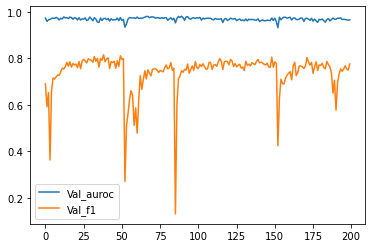

In [9]:
# Plotting stats for the full model
filename = os.path.join("models","pytorch","weights_deeplab_lr0.0001_beta_0.7_0.9999_200epochs.csv")

#filename = os.path.join("models","pytorch","weights_deeplab_3_lr0.0001_beta_0.9_0.9999.csv")
y = pd.read_csv(filename)["Validation_auroc"].values
x = np.arange(len(y))
plt.plot(x,y, label="Val_auroc")
y = pd.read_csv(filename)["Validation_f1_score"].values
x = np.arange(len(y))
plt.plot(x,y, label="Val_f1")
plt.legend()
plt.savefig('DL_auroc.png')

In [10]:
import cv2
def plot_images_eval(n, model, DataLoader):
    torch.cuda.empty_cache()
    for batch, (t_image, mask) in enumerate(DataLoader):
        outputs = model(t_image)
        y_pred = outputs['out']
        y_pred = np.squeeze(y_pred > 0.1)
        plt1 = plt.figure()
        plt1 = plt.imshow(y_pred[0])
        plt2 = plt.figure()
        plt2 = plt.imshow(mask.data[0])
        plt3 = plt.figure()
        image = t_image[0].T
        image = torch.movedim(image,(0,1,2),(1,0,2)).numpy()
        image = (image).astype(np.uint8)
        image = image[...,::-1]

        i0 = image[:,:,0][:,:,np.newaxis]
        i1 = image[:,:,1][:,:,np.newaxis]
        i2 = image[:,:,2][:,:,np.newaxis]
        new_image = np.concatenate((i2,i1),axis = 2)
        new_image = np.concatenate((new_image,i0),axis = 2)
        plt3 = plt.imshow(new_image)
        if batch+1 == n:
            break      
model = torch.load('models/pytorch/weights_deeplab_4.pt')
model.to("cpu");
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
#plot_images_eval(10, model, test_dataloader)

In [11]:
import cv2
def plot_images_flat_eval(n, model, DataLoader,title = False):
    torch.cuda.empty_cache()
    #change save fodler here!!
    path='plots/images/fcn/'
    try:
        os.mkdir(path)
    except OSError as error:
        print(error)    
    for batch, (t_image, mask) in enumerate(DataLoader):
        outputs = model(t_image)
        y_pred = outputs['out']
        y_pred = np.squeeze(y_pred > 0.1)
        print(batch)
        for i in range(len(y_pred)):
            fig,(ax1,ax2,ax3) = plt.subplots(1,3)
            
            ax1.imshow(y_pred[i])
            if title: #implement name
                fig.suptitle()
                fig.tight_layout();
                plt.subplots_adjust(top=1.2);
            else:
                fig.suptitle('pred vs target vs real image')
                fig.tight_layout();
                plt.subplots_adjust(top=1.4);
            
            ax2.imshow(mask.data[i])
            image = t_image[i].T
            image = torch.movedim(image,(0,1,2),(1,0,2)).numpy()
            image = (image).astype(np.uint8)
            image = image[...,::-1]

            i0 = image[:,:,0][:,:,np.newaxis]
            i1 = image[:,:,1][:,:,np.newaxis]
            i2 = image[:,:,2][:,:,np.newaxis]
            new_image = np.concatenate((i2,i1),axis = 2)
            new_image = np.concatenate((new_image,i0),axis = 2)
            ax3.imshow(new_image)
            

            save_path = os.path.join(path,str(batch*2+i))
            fig.savefig(save_path)
        if batch+1 == n:
            break
            
model = torch.load('models/pytorch/fcn_resnet50_200epoch.pt')
#model = torch.load('models/pytorch/weights_deeplab_lr0.0001_beta_0.7_0.9999_200epochs.pt')
model.to("cpu");
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
#lot_images_flat_eval(10, model, test_dataloader)


In [12]:
model = torch.load('models/pytorch/weights_deeplab_lr0.0001_beta_0.7_0.9999_200epochs.pt')
model.to("cpu");
print("HEJ")
#plot_images_flat_eval(10, model, test_dataloader)

HEJ


In [13]:
import cv2
def plot_road_images_eval(n, model, DataLoader, plot_tgt = True, title = True):
    torch.cuda.empty_cache()
    #change save folder here!!
    path='plots/road/fcn_road/'
    try:
        os.mkdir(path)
    except OSError as error:
        print(error)   
    for batch, (t_image, mask, name) in enumerate(DataLoader):
        outputs = model(t_image)
        y_pred = outputs['out']
        y_pred = np.squeeze(y_pred > 0.1)
        
        for i in range(len(y_pred)):
            fig, (ax1,ax2) = plt.subplots(1,2)
            #print("a")
            #ax1.figure()
            #print(t_image[0])
            ax1.imshow(y_pred[i])
            if title:
                fig.suptitle(name[i]);
                fig.tight_layout();
                plt.subplots_adjust(top=1.2);
            if plot_tgt:
                #print("b")
                plt2 = plt.figure()
                plt2 = plt.imshow(mask.data[i])
                #if title:
                    #plt2 = ax1.set_title(name[i])

            #print("c")
            #ax2.figure()
            image = t_image[i].T
            image = torch.movedim(image,(0,1,2),(1,0,2)).numpy()
            image = (image).astype(np.uint8)
            image = image[...,::-1] # flip rgb
            i0 = image[:,:,0][:,:,np.newaxis]
            i1 = image[:,:,1][:,:,np.newaxis]
            i2 = image[:,:,2][:,:,np.newaxis]
            new_image = np.concatenate((i2,i1),axis = 2)
            new_image = np.concatenate((new_image,i0),axis = 2)
            #print(i0.shape)
            ax2.imshow(new_image)
            #print(image[:,:,:])
            
            save_path = os.path.join(path,str(batch*2+i))
            fig.savefig(save_path)
        if batch+1 == n:
            break      
model = torch.load('models/pytorch/weights_deeplab_3_lr0.0001_beta_0.9_0.9999.pt')
model.to("cpu");

In [14]:
#plot_images_eval(2, model, test_dataloader)

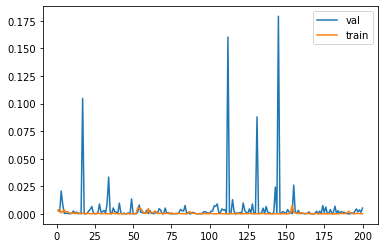

In [15]:
# hyper parameter evaluation:
def plot_loss_csv(csv):
    csv_path = os.path.join("models","pytorch", csv)
    y1 = pd.read_csv(csv_path)["Validation_loss"].values
    y2 = pd.read_csv(csv_path)["Train_loss"].values
    #print(filename, y)
    x = np.arange(0,len(y1))+1
    #print(name, y)
    #with plt.style.context("fivethirtyeight"):
    plt.plot(x,y1,label='val')
    plt.plot(x,y2,label='train')
    plt.legend()
    #plt.rcParams['figure.figsize'] = [40, 2]
    
    plt.savefig('plots/loss/deeplab_loss.png')
    plt.show()


csv = "weights_deeplab_lr0.0001_beta_0.7_0.9999_200epochs.csv"

plot_loss_csv(csv)

## Testing

In [16]:
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Testing on road-data

[Errno 17] File exists: 'plots/road/fcn_road/'
GT_2021-06-18T07_59_48.000Z_CT_1622493461.4599133_9.736682667_56.638634.jpg
GT_2021-06-18T07_59_48.000Z_CT_1622493460.91509_9.736682667_56.638634.jpg


/tmp/ipykernel_1680309/2076500695.py:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2981.)
  image = t_image[i].T


GT_2021-06-18T07_59_50.000Z_CT_1622493462.9575884_9.736851667_56.639247833.jpg
GT_2021-06-18T07_59_48.000Z_CT_1622493461.3751595_9.736682667_56.638634.jpg
GT_2021-06-18T07_59_50.000Z_CT_1622493463.1845543_9.736851667_56.639247833.jpg
GT_2021-06-18T07_59_49.000Z_CT_1622493462.3525488_9.736770167_56.638942667.jpg
GT_2021-06-18T07_59_49.000Z_CT_1622493462.2122214_9.736770167_56.638942667.jpg
GT_2021-06-18T07_59_47.000Z_CT_1622493460.606198_9.7365875_56.6383265.jpg
GT_2021-06-18T07_59_47.000Z_CT_1622493460.344549_9.7365875_56.6383265.jpg
GT_2021-06-18T07_59_49.000Z_CT_1622493461.8727171_9.736770167_56.638942667.jpg
GT_2021-06-18T07_59_50.000Z_CT_1622493463.0061996_9.736851667_56.639247833.jpg
GT_2021-06-18T07_59_50.000Z_CT_1622493463.1150787_9.736851667_56.639247833.jpg
GT_2021-06-18T07_59_49.000Z_CT_1622493462.5444636_9.736770167_56.638942667.jpg
GT_2021-06-18T07_59_48.000Z_CT_1622493460.8310275_9.736682667_56.638634.jpg
GT_2021-06-18T07_59_47.000Z_CT_1622493460.426628_9.7365875_56.638326

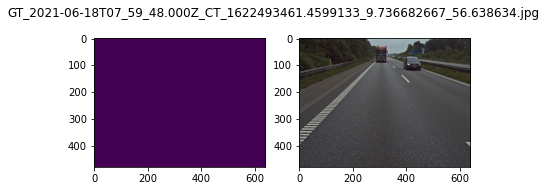

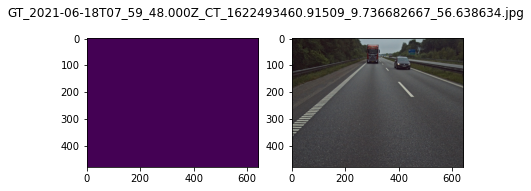

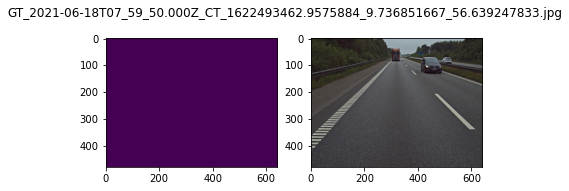

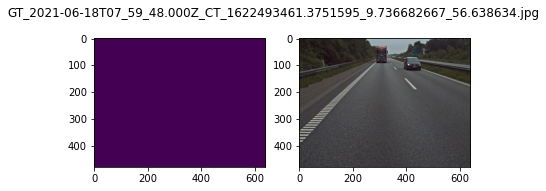

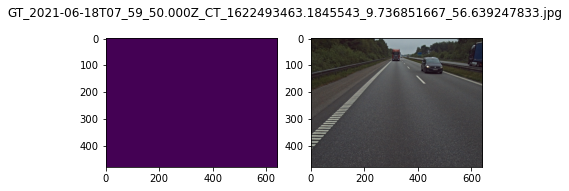

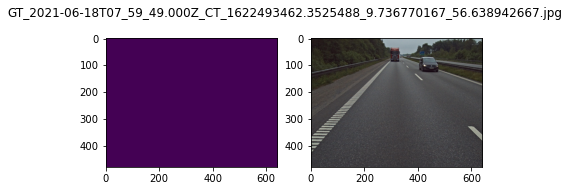

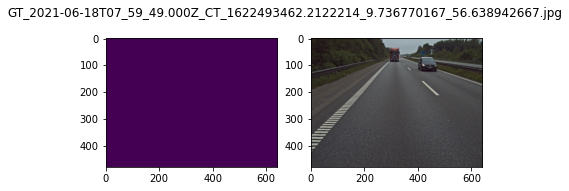

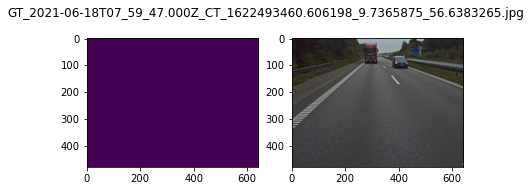

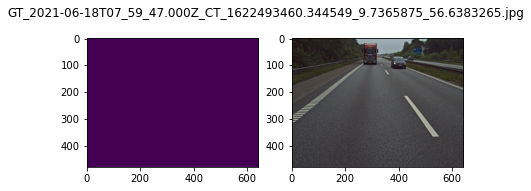

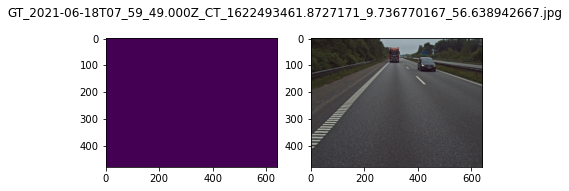

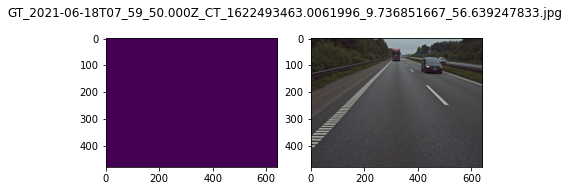

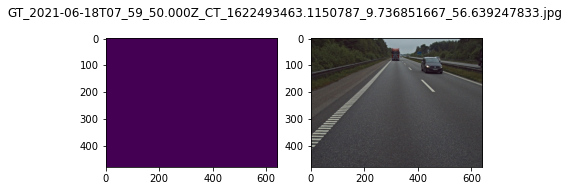

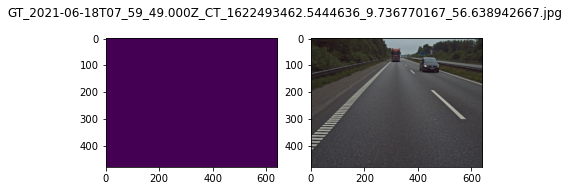

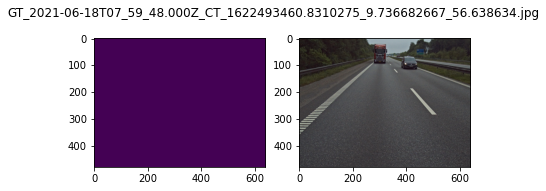

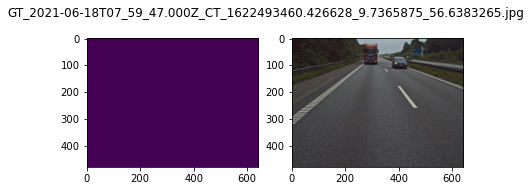

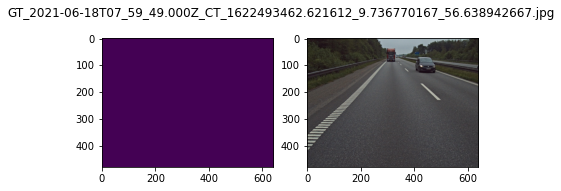

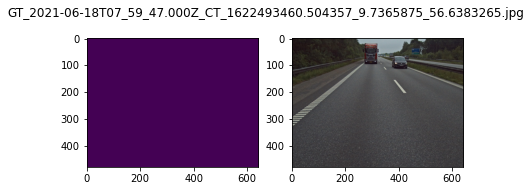

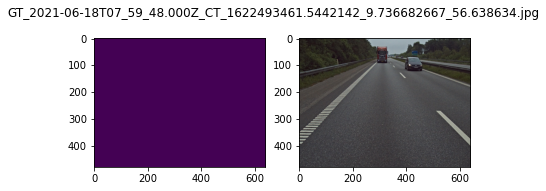

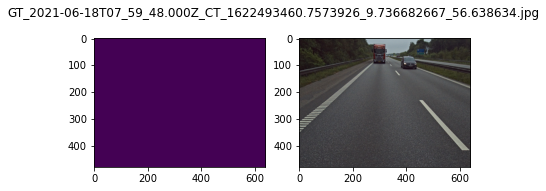

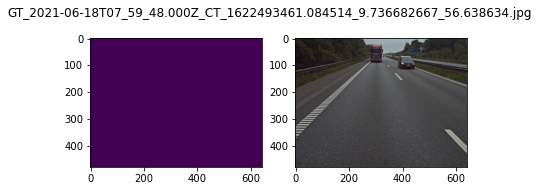

In [17]:
dataset = RoadLoad_seq()
model = torch.load('models/pytorch/weights_deeplab_lr0.0001_beta_0.7_0.9999_200epochs.pt')
#model = torch.load('models/pytorch/fcn_resnet50_200epoch.pt')

model.to("cpu");
road_loader = DataLoader(dataset, batch_size=2, shuffle=False)
plot_road_images_eval(10, model, road_loader, plot_tgt=False)

##### 